In [1]:
from datasets import load_dataset

# The Dataset

In [2]:
emotions = load_dataset("emotion")

/home/phuonglh/miniconda/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## From Dataset to DataFrame

In [4]:
import pandas as pd

In [5]:
df = emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Class Distribution

In [7]:
import matplotlib.pyplot as plt

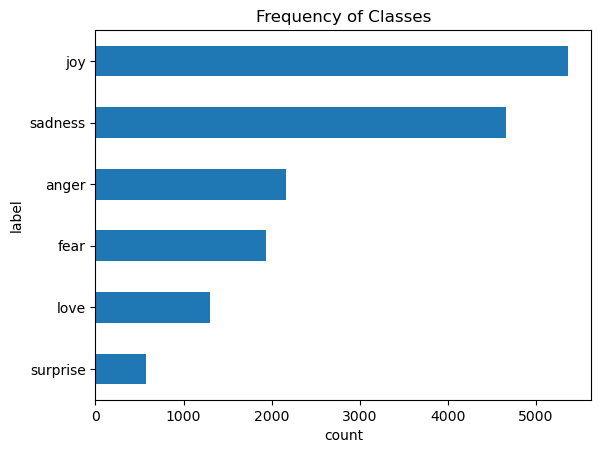

In [8]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.xlabel("count")
plt.ylabel("label")
plt.show()

## Tweets Length

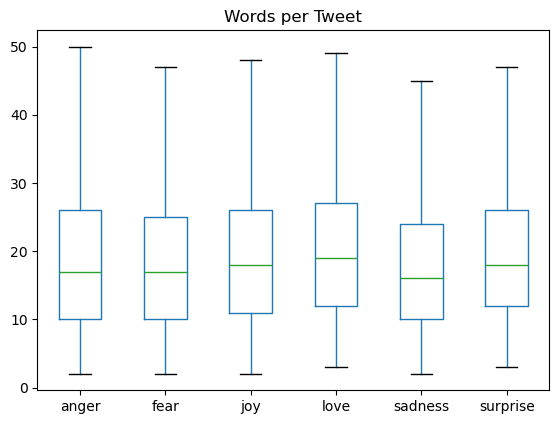

In [9]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
emotions.reset_format()

# From Text to Tokens

In [11]:
from transformers import AutoTokenizer

In [12]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/phuonglh/miniconda/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
text = "Tokenizing text is a core task of NLP."
print(text)

Tokenizing text is a core task of NLP.


In [14]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [16]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [17]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

## Tokening the Dataset

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [19]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [21]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

# Training a Text Classifier

## Transformers as Feature Extractors

In [22]:
from transformers import AutoModel
import torch

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
print(device)

cuda


In [25]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [26]:
def extract_hidden_states(batch):
    # place model inputs on the GPU
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [27]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [28]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [29]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [30]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [31]:
emotions_hidden["train"]["hidden_state"].shape

torch.Size([16000, 768])

In [32]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])custom_tweet = "I saw a movie today and it was really good."
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

In [33]:
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [34]:
y_train.shape, y_valid.shape

((16000,), (2000,))

In [35]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [36]:
# scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

In [37]:
# initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

In [38]:
# create a df of 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["x1", "x2"])
df_emb["label"] = y_traincustom_tweet = "I saw a movie today and it was really good."
df_emb.head()

,x1,x2,label
0,4.367732,6.429637,0
1,-3.264022,5.745227,0
2,5.029340,2.763407,3
3,-2.607856,3.946796,2
4,-3.597085,3.822364,3


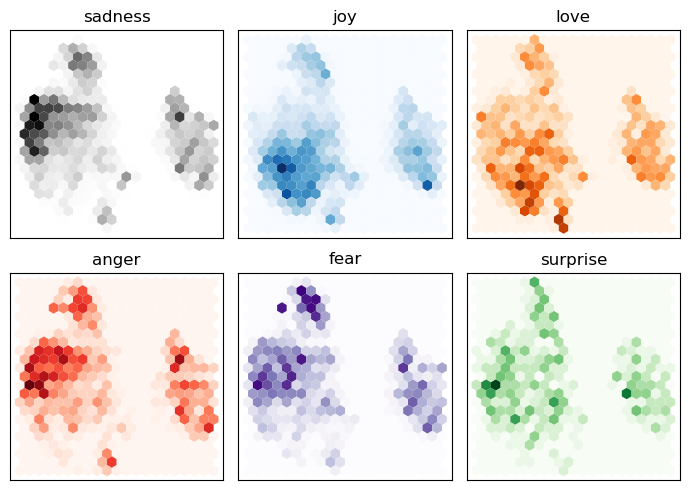

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["x1"], df_emb_sub["x2"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)
lr.score(X_valid, y_valid)

0.6325

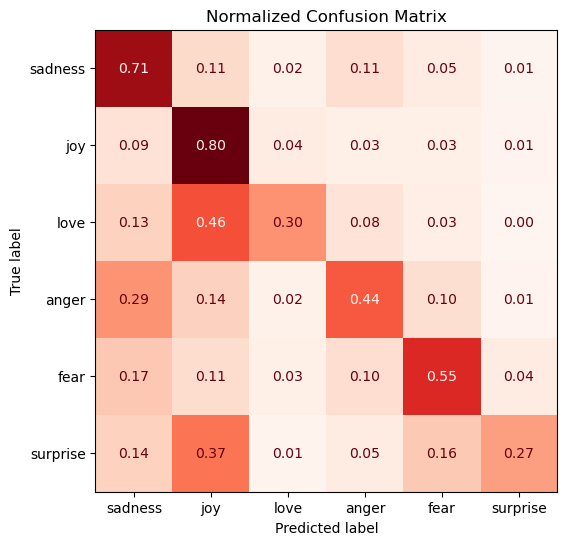

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Reds", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

y_preds = lr.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In [42]:
from transformers import AutoModelForSequenceClassification

In [43]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

/home/phuonglh/miniconda/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}



In [47]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, weight_decay=0.01,
    evaluation_strategy="epoch", disable_tqdm=False, logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error")


In [48]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"], custom_tweet = "I saw a movie today and it was really good."
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.172200,0.181989,0.926000,0.927026
2,0.115100,0.158577,0.936500,0.937323
3,0.095100,0.165587,0.937000,0.937681
4,0.078300,0.154022,0.935500,0.935144
5,0.064300,0.152363,0.937000,0.936960


TrainOutput(global_step=1250, training_loss=0.10497797241210938, metrics={'train_runtime': 202.1321, 'train_samples_per_second': 395.781, 'train_steps_per_second': 6.184, 'total_flos': 1800857154240000.0, 'train_loss': 0.10497797241210938, 'epoch': 5.0})

In [49]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [50]:
preds_output.metrics

{'test_loss': 0.1523633748292923,
 'test_accuracy': 0.937,
 'test_f1': 0.9369603719485199,
 'test_runtime': 1.3027,
 'test_samples_per_second': 1535.233,
 'test_steps_per_second': 24.564}

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)

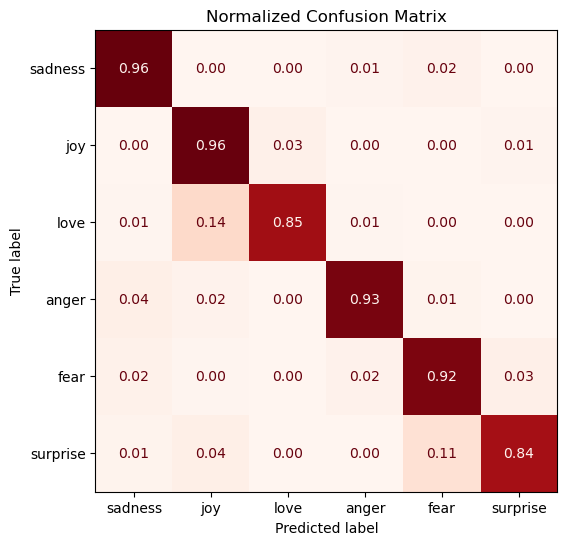

In [53]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis

In [55]:
from torch.nn.functional import cross_entropy

In [56]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [57]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [61]:
# Get data samples with the highest losses:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1195,i always think about are act the way i want to...,anger,joy,8.386295
1950,i as representative of everything thats wrong ...,surprise,sadness,7.765588
1509,i guess this is a memoir so it feels like that...,joy,fear,7.355556
1801,i feel that he was being overshadowed by the s...,love,sadness,7.070710
1963,i called myself pro life and voted for perry w...,joy,sadness,6.898376
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.574423
871,i feel sure is greater to those who are not da...,joy,love,5.079933
292,i can say is that i feel like myself when i pu...,love,joy,4.946506
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.762655
1836,i got a very nasty electrical shock when i was...,fear,anger,4.752141


In [62]:
# Get data samples with lowest losses:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1619,i sat in the car and read my book which suited...,joy,joy,0.000703
11,i was dribbling on mums coffee table looking o...,joy,joy,0.000705
1873,i feel practically virtuous this month i have ...,joy,joy,0.000706
212,i own the brushes are constantly used and i fe...,joy,joy,0.000716
669,i am not feeling very joyful today its been a ...,joy,joy,0.000718
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.000722
856,i feel is more energetic in urban singapore th...,joy,joy,0.000726
752,i really do like the feeling of accomplishing ...,joy,joy,0.000728
1263,i feel this way about blake lively,joy,joy,0.000730
723,i was able to go to a st party i am back feeli...,joy,joy,0.000730
